In [77]:
# Physical activities monitoring has been a very active research problem in data science due to its practical application in health
# care. Many authors have demonstrated successful classification of various physical activities (lying, sitting/standing, running,
# walking, jumping, ascending stairs, descending stairs, etc.) based on different sets of sensors (mostly inertial sensors and heart rate sensor)
# attached on the subjects. As the use of sensors should be kept minimal for practical use, choosing the right types of sensors,
# the amount for each of them and their placement on the subjects in such a way to maximize the classification efficiency is of
# most interest.

# The PAMAP2 Physical Activity Monitoring dataset contains data of 18 different physical activities, performed by 9 subjects 
# wearing 3 inertial measurement units and a heart rate monitor. However, as pointed out in [1-5], this set of sensors with 
# their corresponding placement on the subject does not give favorable information to help distinguish between sitting and standing activity.
# In specific, the confusion rate between sit and stand is over 5%, much higher than other activities classification's confusion rate (typically 1-2%)
# In order to distinguish between these two postures, the authors of [1-3] suggested that an extra IMU should be mounted on the thigh of the subjects. 
# This not only increases the number of sensors used, but also causes inconvenience to the users. Having a sensor mounting on one's thigh is much more
# uncomfortable than having them on one's ankle, chest and wrist. 

# This project explores the sitting/standing classification using the PAMAP2 dataset. This could be considered an extension to 
# the work of of [3]. The key observation is that while it's diffcult to distinguish between sitting and standing using
# the aforementioned set of sensors in general situation, it might be easier when the subject is static. As an example, when standing still people
# prefer to have their arms straigt down, while when sitting still people mostly place their hands on their laps or on a nearby table
# (if there is one). Also, when standing still, the ankles are mostly straight, while when standing still it's very likely to make
# an angle to the normal direction of the ground. All these observations translate into the conditions on the sensor readings (acceleration
# and angular velocity) to help us construct features for our classification problem. 

# REFERECNCES
# [1] A. Reiss and D. Stricker. Introducing a New Benchmarked Dataset for Activity Monitoring. The 16th IEEE International Symposium on Wearable Computers (ISWC), 2012. 
# [2] A. Reiss and D. Stricker. Creating and Benchmarking a New Dataset for Physical Activity Monitoring. The 5th Workshop on Affect and Behaviour Related Assistance (ABRA), 2012. 
# [3] A. Reiss. PhD dissertation. 2014
# [4] Miikka Ermes, Juha Pärkkä, Jani Mäntyjärvi, and Ilkka Korhonen. Detection of daily activities and sports with wearable sensors in controlled and uncontrolled conditions. IEEE Transactions on Information Technology in Biomedicine, 12(1):20–26, January 2008.
# [5] Juha Pärkkä, Luc Cluitmans, and Miikka Ermes. Personalization algorithm for real-time activity recognition using PDA, wireless motion bands, and binary decision tree. IEEE Transactions on Information Technology in Biomedicine, 14(5):1211–1215, September 2010.

import pandas as pd
import numpy as np
import math as m
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# To begin, let's first explore the data. A baseline classification can be calcualted by naively selecting features as the mean of each of the sensor readings.
# In line with [1-3], for each subject, features are calculated for each of the sub-sample data of size sample_size
sample_size = 500 

# which corresponds roughly to 5 second of duration. The computed features are pushed into a feature handle 
feature_arr = []

# read data for each of the subject. The file names are subject101 - subject108. Note that we ignore the last subject (subject109) as this file has very few data points compared to others 
    
src = 'C:/Users/nam/Desktop/Nam ASUS - data back up/SEMIRIS TECHNOLOGY/PROJECTS/Data Science/PAMAP2_Dataset/Protocol/subject10'
cols = np.array(['Time','ActID','HR','T_hand','Ax_hand','Ay_hand','Az_hand','A1x_hand','A1y_hand','A1z_hand','Wx_hand','Wy_hand','Wz_hand','Mx_hand','My_hand','Mz_hand','Qx_hand','Qy_hand','Qz_hand','Q0_hand','T_chest','Ax_chest','Ay_chest','Az_chest','A1x_chest','A1y_chest','A1z_chest','Wx_chest','Wy_chest','Wz_chest','Mx_chest','My_chest','Mz_chest','Qx_chest','Qy_chest','Qz_chest','Q0_chest','T_ankle','Ax_ankle','Ay_ankle','Az_ankle','A1x_ankle','A1y_ankle','A1z_ankle','Wx_ankle','Wy_ankle','Wz_ankle','Mx_ankle','My_ankle','Mz_ankle','Qx_ankle','Qy_ankle','Qz_ankle','Q0_ankle'])

for t in range(1,9):
    srcfile = src + str(t) + '.dat'     
    data = np.genfromtxt(srcfile, delimiter=' ')
    df = pd.DataFrame(data, columns = cols)
    
    # take only data corresponds to sitting or standing
    df = df[(df['ActID'] == 2.0) | (df['ActID'] == 3.0)]
    
    # let's just use the accelerometre and gyroscope sensor readings, and let's focus only on the ankle and wrist (it turns out that data on the chest does not help much, as expected) 
    df = df[['ActID','Ax_hand','Ay_hand','Az_hand','Wx_hand','Wy_hand','Wz_hand','Ax_ankle','Ay_ankle','Az_ankle','Wx_ankle','Wy_ankle','Wz_ankle']]
    
    # clear up the NaN. It turns out that NaN appears in chunk, not intermittenly so that we may interpolate. So there's no option but to discard them
    df = df.dropna(axis = 0, how = 'any')   
    
    # sitting data
    df_sit = df[df['ActID'] == 2.0]
    
    # standing data
    df_stand = df[df['ActID'] == 3.0]
    
    df_sit = df_sit.reset_index()
    df_stand = df_stand.reset_index()
    
    # Now let's focus on the sitting data. 
    sample_num_sit = df_sit.shape[0]//sample_size
    sample_num_stand = df_stand.shape[0]//sample_size
    
    # For each of the sub-sample, calculate the necessary features. For this base line classification, we just use the mean of sensor readings
    for i in range(0,sample_num_sit):
        df_sub = df_sit[i*sample_size:(i+1)*sample_size]
        Ax_hand_mean = np.mean(df_sub['Ax_hand'])
        Ay_hand_mean = np.mean(df_sub['Ay_hand'])
        Az_hand_mean = np.mean(df_sub['Az_hand'])
        Wx_hand_mean = np.mean(df_sub['Wx_hand'])
        Wy_hand_mean = np.mean(df_sub['Wy_hand'])
        Wz_hand_mean = np.mean(df_sub['Wz_hand'])
        Ax_ankle_mean = np.mean(df_sub['Ax_ankle'])
        Ay_ankle_mean = np.mean(df_sub['Ay_ankle'])
        Az_ankle_mean = np.mean(df_sub['Az_ankle'])
        Wx_ankle_mean = np.mean(df_sub['Wx_ankle'])
        Wy_ankle_mean = np.mean(df_sub['Wy_ankle'])
        Wz_ankle_mean = np.mean(df_sub['Wz_ankle'])
          
        # features are pushed into the feature handle
        feature_arr.append([2.0,Ax_hand_mean,Ay_hand_mean,Az_hand_mean,Wx_hand_mean,Wy_hand_mean,Wz_hand_mean, Ax_ankle_mean, Ay_ankle_mean,Az_ankle_mean, Wx_ankle_mean, Wy_ankle_mean,Wz_ankle_mean])
        
    # similar features are calculated for the standing sub-sample
    for i in range(0,sample_num_stand):
        df_sub = df_stand[i*sample_size:(i+1)*sample_size]
        Ax_hand_mean = np.mean(df_sub['Ax_hand'])
        Ay_hand_mean = np.mean(df_sub['Ay_hand'])
        Az_hand_mean = np.mean(df_sub['Az_hand'])
        Wx_hand_mean = np.mean(df_sub['Wx_hand'])
        Wy_hand_mean = np.mean(df_sub['Wy_hand'])
        Wz_hand_mean = np.mean(df_sub['Wz_hand'])
        Ax_ankle_mean = np.mean(df_sub['Ax_ankle'])
        Ay_ankle_mean = np.mean(df_sub['Ay_ankle'])
        Az_ankle_mean = np.mean(df_sub['Az_ankle'])
        Wx_ankle_mean = np.mean(df_sub['Wx_ankle'])
        Wy_ankle_mean = np.mean(df_sub['Wy_ankle'])
        Wz_ankle_mean = np.mean(df_sub['Wz_ankle'])
          
        # features are pushed into the feature handle
        feature_arr.append([3.0,Ax_hand_mean,Ay_hand_mean,Az_hand_mean,Wx_hand_mean,Wy_hand_mean,Wz_hand_mean, Ax_ankle_mean, Ay_ankle_mean,Az_ankle_mean, Wx_ankle_mean, Wy_ankle_mean,Wz_ankle_mean])
        
# Now we are ready to construct the dataframe 
feature_data = pd.DataFrame(feature_arr, columns = ['ActID','Ax_hand_mean','Ay_hand_mean','Az_hand_mean','Wx_hand_mean','Wy_hand_mean','Wz_hand_mean', 'Ax_ankle_mean', 'Ay_ankle_mean','Az_ankle_mean', 'Wx_ankle_mean', 'Wy_ankle_mean','Wz_ankle_mean'])

# decision tree 
Y = feature_data['ActID']
X = feature_data.drop('ActID', axis=1)

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.4,random_state=1)
depth = np.zeros(20)

for iteration in range(0,50):
    for i in range(0,20):
        clf = DecisionTreeClassifier(max_depth=i+1)
        clf = clf.fit(X_train,Y_train)
        depth[i] = depth[i] + clf.score(X_test,Y_test)/50
print(depth)

# Xgboost
model = XGBClassifier(learning_rate =0.08,n_estimators=1000,max_depth=7,min_child_weight=1,gamma=0.2,subsample=0.8,colsample_bytree=0.8,objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
model.fit(X_train, Y_train)
print(model)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# The best accuracy can be seen to be 94.26% using Xgboost. This is well recognized in mentioned  

[ 0.89189189  0.88851351  0.91554054  0.93108108  0.91986486  0.91344595
  0.89783784  0.90087838  0.90060811  0.90094595  0.89945946  0.90135135
  0.90040541  0.90135135  0.90040541  0.90148649  0.90081081  0.89945946
  0.89871622  0.90074324]
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.2, learning_rate=0.08, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)
Accuracy: 94.26%


In [78]:
# Let'show that we may be able to improve the accuracy by looking at the static data, especially at the hand's IMU. 
# First, we create a master dataset by pulling all data from all subjects and put into df

df_test = pd.DataFrame()
for t in range(1,9):
    srcfile = src + str(t) + '.dat'     
    data = np.genfromtxt(srcfile, delimiter=' ')
    temp = pd.DataFrame(data, columns = cols)
    df_test = df_test.append(temp)
    
# sitting data
df_sit = df_test[df_test['ActID'] == 2.0]
df_sit.dropna(axis = 0, how = 'any')
# standing data
df_stand = df_test[df_test['ActID'] == 3.0]
df_stand.dropna(axis = 0, how = 'any')
    
df_sit = df_sit.reset_index()
df_stand = df_stand.reset_index()

# we place static constrain on the data. Note that as the natural movement of ankle, chest and wrist are rotation, not translation, gyroscopes are the better sensors to define stillness. 
# static condition is defined as a constrain on the magnitude square of angular speed (in rad/s)
static_limit = 0.1 

# sitting data with static hand
df_sit_hand_static = df_sit[df_sit['Wx_hand']*df_sit['Wx_hand'] + df_sit['Wy_hand']*df_sit['Wy_hand'] + df_sit['Wz_hand']*df_sit['Wz_hand'] < static_limit]

# standing data with static hand
df_stand_hand_static = df_stand[df_stand['Wx_hand']*df_stand['Wx_hand'] + df_stand['Wy_hand']*df_stand['Wy_hand'] + df_stand['Wz_hand']*df_stand['Wz_hand'] < static_limit]
  

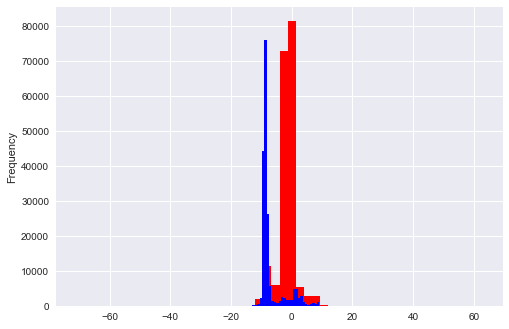

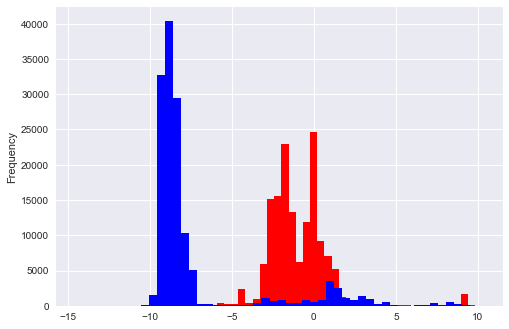

In [79]:
# Second, we need to identify the orientation of the IMU as they were mounted on different places in the subject's body (for ex, what direction is the z component of the acceleration of
# the IMU mounted on the ankle pointing to?), since this (very important) information was not given in the dataset. Turns out the this is not a very difficult task. For example, 
# at the ankle there must be an acceleration component in which when people are standing, most of the time it will be 9.81m/c2. That component will point upward normal 
# to the ground. Another example with the ankle is that there must be another component which is mostly either positive or negative (up to some error) for both sitting and standing.
# This is because people's legs barely form an up-side-down V-shape, especially when they are still. To keep the presentation concise, we will not dive into too much details with this 
# step, keeping in mind that these and similar observations can be made to help us identify all IMU's orientation.    
        

# The difference in histogram distribution of the wrist's Ax-component (pointing along the arm) between sitting and standing is not clear in general
plt.figure()
df_sit['Ax_hand'].plot.hist(stacked = True, bins = 50, color = 'r')
df_stand['Ax_hand'].plot.hist(stacked = True, bins = 50, color = 'b')
plt.show()

# but should be very clear when we impose static condition
plt.figure()
df_sit_hand_static['Ax_hand'].plot.hist(stacked = True, bins = 50, color = 'r')
df_stand_hand_static['Ax_hand'].plot.hist(stacked = True, bins = 50, color = 'b')
plt.show()

# which makes sense because when standing still people are more likely to place their arm straight down

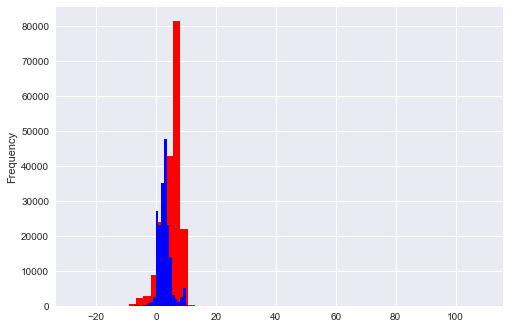

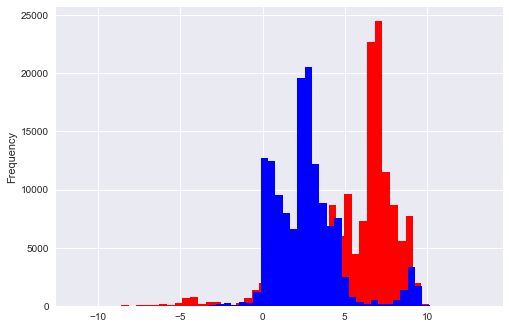

In [80]:
# similar observation can be made for the wrist's Az-component (pointing outward and perpendicular to the arm)

plt.figure()
df_sit['Az_hand'].plot.hist(stacked = True, bins = 50, color = 'r')
df_stand['Az_hand'].plot.hist(stacked = True, bins = 50, color = 'b')
plt.show()

plt.figure()
df_sit_hand_static['Az_hand'].plot.hist(stacked = True, bins = 50, color = 'r')
df_stand_hand_static['Az_hand'].plot.hist(stacked = True, bins = 50, color = 'b')
plt.show()

# which also makes sense because when sitting still people prefer to place their arm on their lap or on a 
# nearby table. On the other hand, when standing still people barely raise their arm which Az much smaller 

In [86]:
# given what we just discussed, let's preliminarily explore the possibility of increasing sitting/standing classification by focusing on
# static data. 

# As previously, we sub-sample the data and calculate features for each of the subsampple
static_limit = 0.1 
feature_arr_static = []

for t in range(1,9):
    srcfile = src + str(t) + '.dat'     
    data = np.genfromtxt(srcfile, delimiter=' ')
    df = pd.DataFrame(data, columns = cols)
    
    # take only data corresponds to sitting or standing
    df = df[(df['ActID'] == 2.0) | (df['ActID'] == 3.0)]
    
    # use the accelerometre and gyroscope sensor readings, and let's focus only on the ankle and wrist (it turns out that data on the chest does not help much, as expected) 
    df = df[['ActID','Ax_hand','Ay_hand','Az_hand','Wx_hand','Wy_hand','Wz_hand','Ax_ankle','Ay_ankle','Az_ankle','Wx_ankle','Wy_ankle','Wz_ankle']]
    
    # clear up the NaN. It turns out that NaN appears in chunk, not intermittenly so that we may interpolate. So there's no option but to discard them
    df = df.dropna(axis=0,how='any')    
    # sitting data
    df_sit = df[df['ActID'] == 2.0]
    
    # standing data
    df_stand = df[df['ActID'] == 3.0]
    
    df_sit = df_sit.reset_index()
    df_stand = df_stand.reset_index()
    
    # Now let's focus on the sitting data
    sample_num_sit = df_sit.shape[0]//sample_size
    sample_num_stand = df_stand.shape[0]//sample_size
    
    # For each of the sub-sample, calculate the necessary features
    for i in range(0,sample_num_sit):
        df_sub = df_sit[i*sample_size:(i+1)*sample_size]
        
        # static constrain
        df_sub_hand_static = df_sub[df_sub['Wx_hand']*df_sub['Wx_hand'] + df_sub['Wy_hand']*df_sub['Wy_hand'] + df_sub['Wz_hand']*df_sub['Wz_hand'] < static_limit]
        df_sub_ankle_static = df_sub[df_sub['Wx_ankle']*df_sub['Wx_ankle'] + df_sub['Wy_ankle']*df_sub['Wy_ankle'] + df_sub['Wz_ankle']*df_sub['Wz_ankle'] < static_limit]
        
        # Now we are ready to identify and calculate features.  
        
        # 1. People's arms are more straight down when standing than sitting still, which causes x-component of IMU on the wrist is be closer to (-)9.81m/s2 when standing
        Ax_hand_mean = np.mean(df_sub_hand_static['Ax_hand'])
        Ax_hand_down = np.sum(df_sub_hand_static[abs(df_sub_hand_static['Ax_hand'] + 9.8) < 2.0]['Ax_hand'])
        
        # 2. Similarly when sitting still, people prefer to place their arm on their lap or on a table, which causes the z-component of the hand IMU to be closer than 9.81m/s2.  
        Az_hand_mean = np.mean(df_sub_hand_static['Az_hand'])
        Az_hand_lean = np.sum(df_sub_hand_static[abs(df_sub_hand_static['Az_hand'] - 9.81) < 1.5]['Az_hand']) # good
        
        # 3.
        Ay_hand_mean = np.mean(df_sub_hand_static['Ay_hand'])
        
        
        # 4. When standing still, the leg is more likely to be normal to the ground than when sitting still, which translate to x-component of the ankle IMU to be closer to 9.81m/s2
        Ax_ankle_lean = np.sum(df_sub_ankle_static[abs(df_sub_ankle_static['Ax_ankle'] - 9.81) < 1.5]['Ax_ankle'])# moderate 
        
        # 5. When sitting still, there is a higher possibility that the two legs form a V-shape (the correct V-shape, not the up-side-down V-shape). This translate to z-component of
        # the ankle IMU being more negative when sitting
        Az_ankle_mean = np.mean(df_sub_ankle_static['Az_ankle'])# good
        Az_ankle_lean = np.sum(df_sub_ankle_static[df_sub_ankle_static['Az_ankle'] < -2.5]['Az_ankle']) # good
        
        # 6. When standing still, there's a small possibility that legs are placing too much to the front or to the back (with respect to one's heading). This corresponds to y-component
        # of the ankle IMU more restricted 
        Ay_ankle_lean = np.sum(df_sub_ankle_static[df_sub_ankle_static['Ay_ankle'] > 2.0]['Ay_ankle']) # good
        Ay_ankle_lean1 = np.sum(df_sub_ankle_static[df_sub_ankle_static['Ay_ankle'] < -3.0]['Ay_ankle']) # good
        
        # features are pushed into the feature handle
        feature_arr_static.append([2.0,Ax_hand_mean,Ay_hand_mean,Az_hand_mean,Az_hand_lean,Ax_hand_down,Ax_ankle_lean,Az_ankle_mean,Az_ankle_lean,Ay_ankle_lean,Ay_ankle_lean1])
        
    # similar features are calculated for the standing sub-sample
    for i in range(0,sample_num_stand):
        df_sub = df_stand[i*sample_size:(i+1)*sample_size]
        df_sub_hand_static = df_sub[df_sub['Wx_hand']*df_sub['Wx_hand'] + df_sub['Wy_hand']*df_sub['Wy_hand'] + df_sub['Wz_hand']*df_sub['Wz_hand'] < static_limit]
        df_sub_ankle_static = df_sub[df_sub['Wx_ankle']*df_sub['Wx_ankle'] + df_sub['Wy_ankle']*df_sub['Wy_ankle'] + df_sub['Wz_ankle']*df_sub['Wz_ankle'] < static_limit]
        Ax_hand_mean = np.mean(df_sub_hand_static['Ax_hand'])
        Ay_hand_mean = np.mean(df_sub_hand_static['Ay_hand'])
        Az_hand_mean = np.mean(df_sub_hand_static['Az_hand'])
        Az_hand_lean = np.sum(df_sub_hand_static[abs(df_sub_hand_static['Az_hand'] - 9.81) < 1.5]['Az_hand']) # good
        Ax_hand_down = np.sum(df_sub_hand_static[abs(df_sub_hand_static['Ax_hand'] + 9.8) < 2.0]['Ax_hand'])
        Ax_ankle_lean = np.sum(df_sub_ankle_static[abs(df_sub_ankle_static['Ax_ankle'] - 9.81) < 1.5]['Ax_ankle'])# moderate 
        Az_ankle_mean = np.mean(df_sub_ankle_static['Az_ankle'])# good
        Az_ankle_lean = np.sum(df_sub_ankle_static[df_sub_ankle_static['Az_ankle'] < -2.5]['Az_ankle']) # good
        Ay_ankle_lean = np.sum(df_sub_ankle_static[df_sub_ankle_static['Ay_ankle'] > 2.0]['Ay_ankle']) # good
        Ay_ankle_lean1 = np.sum(df_sub_ankle_static[df_sub_ankle_static['Ay_ankle'] < -3.0]['Ay_ankle']) # good
        
        # and pushed into the feature handle        
        feature_arr_static.append([3.0,Ax_hand_mean,Ay_hand_mean,Az_hand_mean,Az_hand_lean,Ax_hand_down,Ax_ankle_lean,Az_ankle_mean,Az_ankle_lean,Ay_ankle_lean,Ay_ankle_lean1])

# Now we are ready to construct the dataframe for the subsequent classification algorithm
feature_data_static = pd.DataFrame(feature_arr_static, columns = ['ActID','Ax_hand_mean','Ay_hand_mean','Az_hand_mean','Az_hand_lean','Ax_hand_down','Ax_ankle_lean','Az_ankle_mean','Az_ankle_lean','Ay_ankle_lean','Ay_ankle_lean1'])

# A few sub-sample does not have static data. Let's ignore them for now
feature_data_static = feature_data_static.dropna(axis=0,how='any')


In [87]:
# decision tree
Y = feature_data_static['ActID']
X = feature_data_static.drop('ActID', axis=1)

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.4,random_state=1)
depth = np.zeros(20)

for iteration in range(0,50):
    for i in range(0,20):
        clf = DecisionTreeClassifier(max_depth=i+1)
        clf = clf.fit(X_train,Y_train)
        depth[i] = depth[i] + clf.score(X_test,Y_test)/50
print(depth)

# Xgboost
model = XGBClassifier(learning_rate =0.08,n_estimators=1000,max_depth=7,min_child_weight=1,gamma=0.2,subsample=0.8,colsample_bytree=0.8,objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
model.fit(X_train, Y_train)
print(model)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# The accuracy is improved to 95.61%

[ 0.89189189  0.90202703  0.90878378  0.93371622  0.94141892  0.94033784
  0.94108108  0.94445946  0.94297297  0.9397973   0.93986486  0.9402027
  0.94081081  0.94074324  0.94        0.94027027  0.93817568  0.93858108
  0.93817568  0.94148649]
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.2, learning_rate=0.08, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)
Accuracy: 95.61%
